# Face Mask Detection
# Import Global Library

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Import Dataset and Function

In [23]:
trn_dir = 'Dataset/Train'
tst_dir = 'Dataset/Test'
val_dir = 'Dataset/Validation/'
eyesglass = 'Dataset/Detect Object/haarcascade_eye_tree_eyeglasses.xml'
eyes = 'Dataset/Detect Object/haarcascade_eye.xml'
face1 = 'Dataset/Detect Object/haarcascade_frontalface_default.xml'
face2 = 'Dataset/Detect Object/haarcascade_frontalface_alt_tree.xml'
face3 = 'Dataset/Detect Object/haarcascade_frontalface_alt.xml'
face4 = 'Dataset/Detect Object/haarcascade_frontalface_alt2.xml'

class DetectObject:
    def __init__(self, img):
        self.img  = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
    
    def detect_object(self, cascade):
        # Copy Image
        img = self.img.copy()
        detect = cv2.CascadeClassifier(cascade)

        # Detect Selected Object in Image
        objects = detect.detectMultiScale(
            self.gray,
            scaleFactor = 1.08,
            minNeighbors= 4
        )

        # Plotting Object with rectangle
        for(x, y, w, h) in objects:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 7)
        
        return img, objects
    
    def model_scan(self, model, cascade, pos, neg):
        img, objects = self.detect_object(cascade)

        object_label = {0: neg, 1: pos}
        object_color = {0: (0, 255, 0), 1: (255, 0, 0)}

        # Render Result Text
        pad_y = 1

        img = self.img

        for i in range (len(objects)):
            (x, y, w, h) = objects[i]
            crop_obj = img[y : y+h, x: x+w]
            crop_obj = cv2.resize(crop_obj, (128, 128))
            crop_obj = np.reshape(crop_obj, [1, 128, 128, 3]) / 255.0

            # Model Prediction
            model_result = model.predict(crop_obj) 

            # Give label and color based on prediction
            label_result = object_label[model_result.argmax()]
            label_color = object_color[model_result.argmax()]

            # Set Text
            (t_w, t_h), _ = cv2.getTextSize(
                label_result,
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.4,
                thickness = 1
            )

            # Set Rectangle
            cv2.rectangle(
                img = img,
                pt1 = (x, y + pad_y),
                pt2 = (x + t_w, y - t_h - pad_y - 6),
                color = label_color,
                thickness= -1
            )

            # Render Text
            cv2.putText(
                img = img,
                text = label_result,
                org = (x, y -6),
                fontFace = cv2.FONT_HERSHEY_DUPLEX,
                fontScale = 0.4,
                color = (255, 255, 255),
                thickness = 1
            )

            # Render Rectangle
            cv2.rectangle(
                img = img,
                pt1 = (x, y),
                pt2 = (x + w, y + h),
                color= label_color,
                thickness= 1
            )

        plt.figure(figsize=(12, 12))
        plt.imshow(img)

        

# Test Face Detection with Haarcascade

In [3]:
list = ['a.jpg', 'b.jpg']
for img in list:
    img = cv2.imread(img)
    detect = DetectObject(img)
    output = detect.detect_object(face1)

# Data Preprocessing for Building The Mask Detection

In [4]:
# Image Data Generator
data_generator = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip= True,
    zoom_range= 0.2,
    shear_range= 0.2
)

train_generator = data_generator.flow_from_directory(
    directory = trn_dir,
    target_size = (128, 128),
    class_mode = 'categorical',
    subset = 'training',
    batch_size = 32
)

# Validation
val_generator = data_generator.flow_from_directory(
    directory = val_dir, 
    target_size =(32, 32),
    class_mode = 'categorical',
    subset = 'validation',
    batch_size = 32
)

# Test Data
test_generator = data_generator.flow_from_directory(
    directory = tst_dir,
    target_size = (128, 128),
    class_mode = 'categorical',
    batch_size = 32
)

Found 10000 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


# Data Learning
## Import Library and Function

In [5]:
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

# def showGraph(history):
#     plt.plot(history.history['loss'], label='train loss')
#     plt.plot(history.history['val_loss'], label='val loss')
#     plt.title('Loss')
#     plt.legend()
#     plt.show()
#     #plt.savefig('LossVal_loss')

#     plt.plot(history.history['accuracy'], label='train acc')
#     plt.plot(history.history['val_accuracy'], label='val acc')
#     plt.title('Accuracy')
#     plt.legend()
#     plt.show()

In [6]:
# Initializing CNN with 19 layers deep
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics="accuracy")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


## Model Training

In [7]:
# Model.fit_generator is DEPRECATED
# model.fit_generator(
#     generator=train_generator,
#     steps_per_epoch=len(train_generator) // 32,
#     epochs=1,
#     validation_data=val_generator,
#     validation_steps=len(val_generator) // 32
# )

# Fit the model on train data along with validation data
model_history = model.fit(
    x = train_generator,
    validation_data = val_generator,
    steps_per_epoch= len(train_generator) // 32,
    epochs = 30
)

Epoch 1/30
9/9 [==============================] - 36s 4s/step - loss: 0.4142 - accuracy: 0.8125
Epoch 2/30
9/9 [==============================] - 35s 4s/step - loss: 0.1922 - accuracy: 0.9340
Epoch 3/30
9/9 [==============================] - 35s 4s/step - loss: 0.1787 - accuracy: 0.9236
Epoch 4/30
9/9 [==============================] - 35s 4s/step - loss: 0.1019 - accuracy: 0.9618
Epoch 5/30
9/9 [==============================] - 37s 4s/step - loss: 0.0695 - accuracy: 0.9792
Epoch 6/30
9/9 [==============================] - 36s 4s/step - loss: 0.0696 - accuracy: 0.9792
Epoch 7/30
9/9 [==============================] - 35s 4s/step - loss: 0.1019 - accuracy: 0.9549
Epoch 8/30
9/9 [==============================] - 38s 4s/step - loss: 0.0685 - accuracy: 0.9826
Epoch 9/30
9/9 [==============================] - 36s 4s/step - loss: 0.0730 - accuracy: 0.9826
Epoch 10/30
9/9 [==============================] - 36s 4s/step - loss: 0.0596 - accuracy: 0.9792
Epoch 11/30
9/9 [======================

## Model Evaluation on Test Set

In [8]:
# Evaluate model performance on test data Using CNN
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

# Save Model
model.save('Dataset/cnn_model.h5')

31/31 [==============================] - 124s 4s/step - loss: 0.0405 - accuracy: 0.9859
Model has a loss of 0.04 and accuracy 98.59%


# Test Model on Sample Image
## Import Library and Function

In [13]:
from keras.models import load_model

1/1 [==============================] - 0s 188ms/step


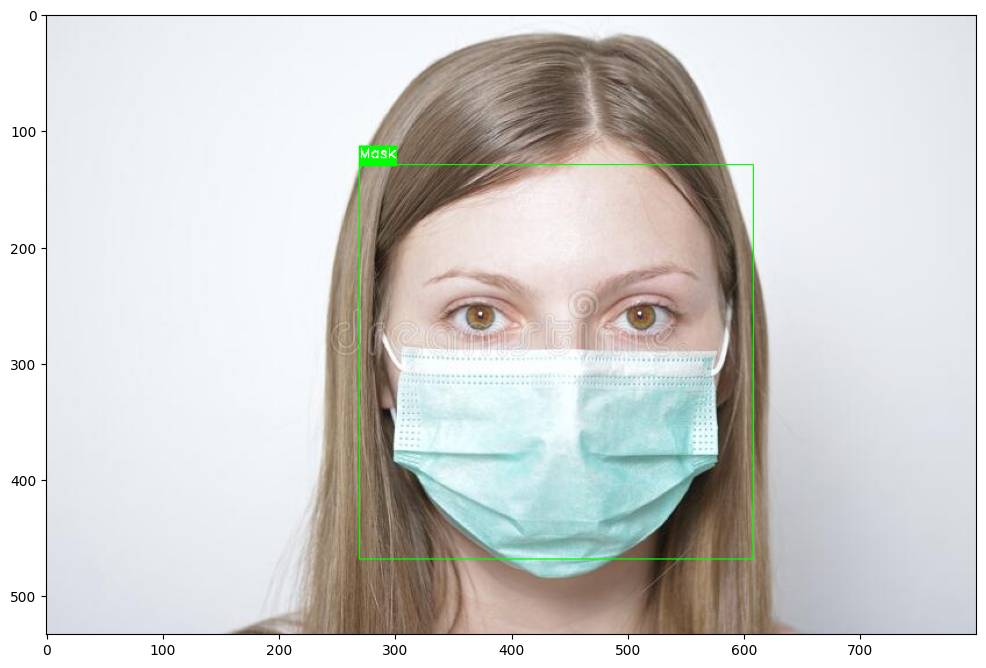

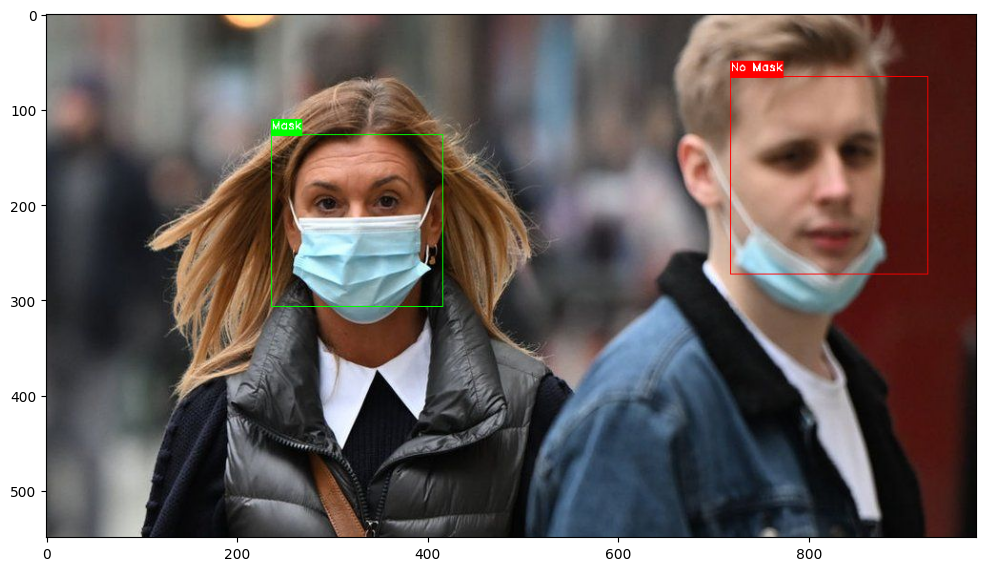

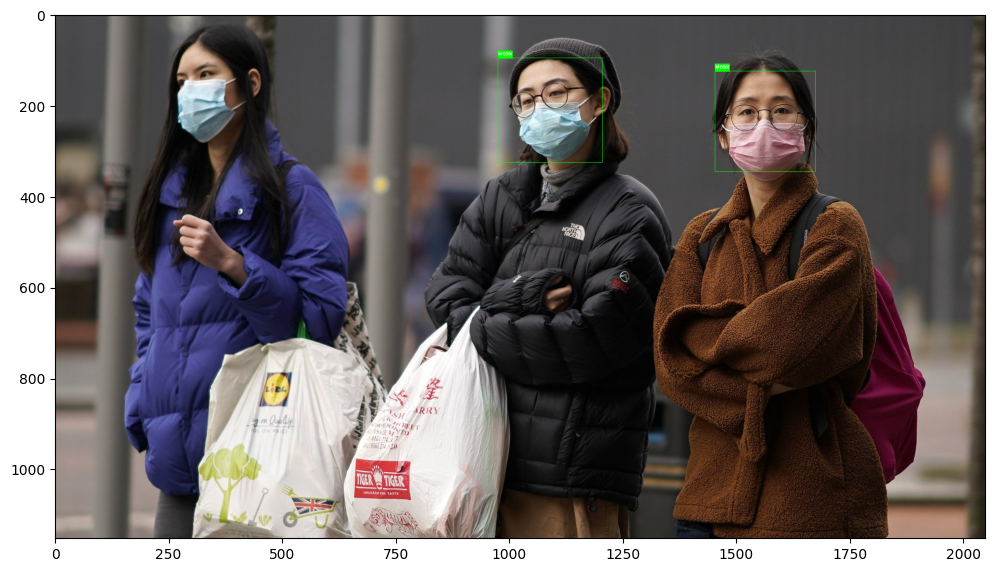

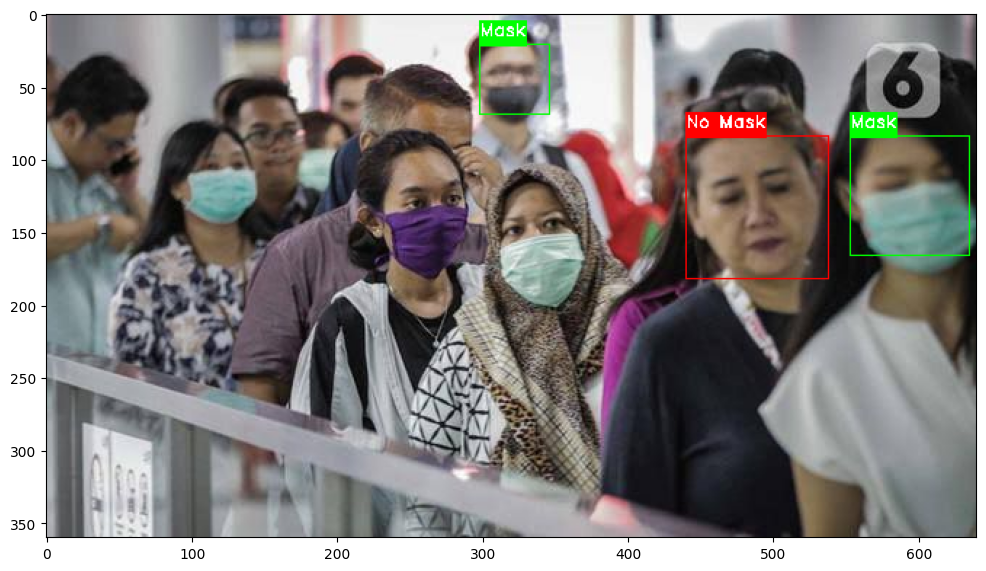

In [25]:
# Load model if you have file model
model = load_model('Dataset/cnn_model.h5')

# Test images
list = ['1.jpg','2.jpg', '3.jpg', '4.jpg']
for img in list:
    img = cv2.imread(img)
    detect = DetectObject(img)
    output = detect.model_scan(model, face4, 'No Mask', 'Mask')

The model won't classify Mask or No Mask if faces are not detected by haarcascade